In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import seaborn as sns; sns.set()

In [2]:
def read_fits(filename):
    """
    Read datacube
    Input: filname and the y and x boundaries: limits = [ymin,ymax,xmin,xmax]
    """
    fits_cube_read = fits.open(filename)
    cube, hdr, var = fits_cube_read[0].data, fits_cube_read[0].header, fits_cube_read[1].data

    """
    Calibrate in wavelength from header keywords
    """
    cdelt3 = hdr['CDELT3'] # the scale
    crval3 = hdr['CRVAL3'] # the starting wavelength
    naxis3 = hdr['NAXIS3'] # the length of the axis
    pixel = np.arange(cube.shape[0])
    lamb = crval3 + (pixel) * cdelt3 #the wavelength ranges
    lamRange =  [crval3 + 0,crval3 + cdelt3*(naxis3-1)] # the first and last wavelength of the spectrum

    return (cube, hdr, var, lamb, lamRange)

In [3]:
filename = 'data/100162/100162_cube_red.fits.gz'
cube, hdr, var, lamb, lamRange = read_fits(filename)

In [4]:
lamb

array([6844.70444553, 6845.29555447, 6845.88666341, ..., 8053.52222765,
       8054.11333659, 8054.70444553])

In [5]:
def flux_diff(file_name):
    
    open_cube = fits.open(file_name)
    fits_cube = open_cube[0].data
    
    central_flux = fits_cube[:,25,25]
    diff_array = np.zeros(shape=(2048,50,50))
    N = 50
        
    for i in range(N-1):
        for j in range(N-1):
            pixel_of_interest_flux = cube[:,i,j]

            flux_diff = central_flux - pixel_of_interest_flux

            diff_array[:,i,j] = flux_diff
            
    return (diff_array)

In [6]:
file_name = 'data/100162/100162_cube_red.fits.gz'

In [7]:
diff_array = flux_diff(file_name)

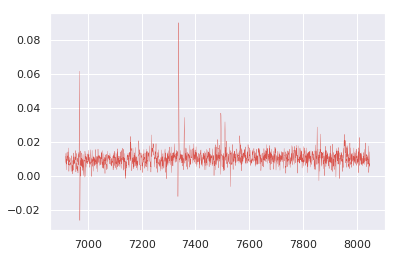

In [8]:
plt.plot(lamb, diff_array[:,27,25], sns.xkcd_rgb["pale red"], linewidth = 0.3)

In [9]:
diff_array[1000,27,25]

0.005828918651709224

In [10]:
'''
- find central pixel flux in RED unbinned cube
- set gas velocity in central pixel to zero
- create zeros in 2048,50,50 array
- at each pixel, take the gas velocity value in +/- km/s
to find the shift in flux from central pixel
- shift central flux accordingly
- store shifted flux in zeros array
'''

'''σ_{res} ~ 30 km/s
RED: spectral sampling 0.596 Å/pixel with a spectral FWHM of 1.59 Å (from 6240 - 7460 Å)
'''

'σ_{res} ~ 30 km/s\nRED: spectral sampling 0.596 Å/pixel with a spectral FWHM of 1.59 Å (from 6240 - 7460 Å)\n'

In [11]:
file_name = 'data/100162/100162_cube_red.fits.gz'
cube_red, hdr_red, var_red, lamb_red, lamRange_red = read_fits(file_name)

In [12]:
central_flux = cube_red[:,25,25] 

In [13]:
central_flux[1000]

0.05767299282153364

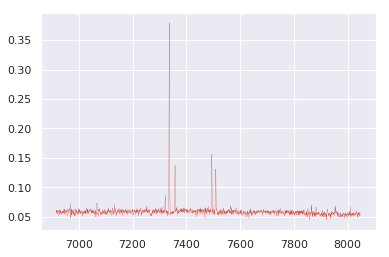

In [14]:
plt.plot(lamb, central_flux, sns.xkcd_rgb["pale red"], linewidth = 0.3)

In [15]:
gasvelocity_fits = 'data/100162/100162_gas-velocity_default_recom-comp.fits'
gasvelocity = fits.open(gasvelocity_fits)

In [16]:
gasvelocity.info()

Filename: data/100162/100162_gas-velocity_default_recom-comp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   (50, 50, 3)   float64   
  1  V_ERR         1 ImageHDU        21   (50, 50, 3)   float32   


In [17]:
gas_veloctiy = gasvelocity[0].data

In [18]:
gas_veloctiy[0,25,25]

-0.5154096496407874

In [19]:
def gas_vel_diff(red_cube, gas_velocity):

    L = 50
 
    red_flux_data = fits.open(red_cube)
    red_flux = red_flux_data[0].data
    central_flux = red_flux[:,25,25]

    gasvelocity = fits.open(gas_velocity)  
    gas_veloctiy_2d = gasvelocity[0].data

    gas_flux_array = np.zeros(shape=(2048,50,50))
    gas_flux_array[:,25,25] = central_flux

    for i in range(L-1):
        for j in range(L-1):
            gas_flux_array[:,i,j] = red_flux[:,i,j] * ( 1 + (gas_veloctiy_2d[0,i,j] / 300000))
    
    return (gas_flux_array)

In [20]:
red_cube = 'data/100162/100162_cube_red.fits.gz'

In [21]:
gas_velocity = 'data/100162/100162_gas-velocity_default_recom-comp.fits'

In [22]:
gas_flux_array = gas_vel_diff(red_cube, gas_velocity)

(7300, 7375)

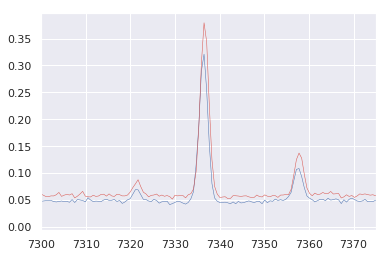

In [23]:
fig,ax = plt.subplots()
plt.plot(lamb, gas_flux_array[:,27,25], linewidth = 0.5)
plt.plot(lamb, central_flux, sns.xkcd_rgb["pale red"], linewidth = 0.5)
ax.set_xlim(7300, 7375)

(7300, 7375)

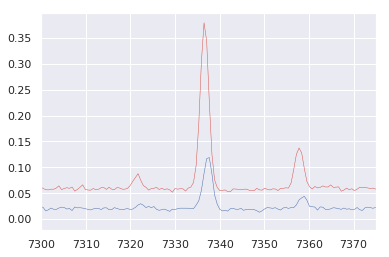

In [24]:
fig,ax = plt.subplots()
plt.plot(lamb, gas_flux_array[:,20,25], linewidth = 0.5)
plt.plot(lamb, central_flux, sns.xkcd_rgb["pale red"], linewidth = 0.5)
ax.set_xlim(7300, 7375)

In [25]:
test_cube_file = 'data/100162/100162_cube_red.fits.gz'
test_cube_data = fits.open(red_cube)

In [26]:
test_cube, test_cube_hdr = test_cube_data[0].data, test_cube_data[0].header

In [27]:
test_cube_hdr['crval3'], test_cube_hdr['cdelt3'], test_cube_hdr['naxis3']
# starting wavelength in angstroms
# angstroms per slice
# 2048 slices

(6844.70444553, 0.5911089399121, 2048)

In [28]:
test_gas_file = 'data/100162/100162_gas-velocity_default_recom-comp.fits'
test_gas_data = fits.open(test_gas_file)

In [29]:
test_gas_velocity = test_gas_data[0].data

In [30]:
(test_cube_hdr['crval3']/10) # starting wavelength in nm

684.470444553

In [31]:
test_gas_velocity[0,30,25] # characteristic gas velocity pixel value

-29.51795177644817

In [32]:
(test_cube_hdr['crval3']/10) * (1 + (test_gas_velocity[0,30,25]/300000)) #starting wavelength in nm

684.4030973344176

In [33]:
pixels = np.arange(test_cube.shape[0])
min_wavelength = test_cube_hdr['crval3']/10
wavelength_range = test_cube_hdr['crval3']/10 + (test_cube_hdr['cdelt3']/10)*pixels-1

In [34]:
pixels, wavelength_range

(array([   0,    1,    2, ..., 2045, 2046, 2047]),
 array([683.47044455, 683.52955545, 683.58866634, ..., 804.35222277,
        804.41133366, 804.47044455]))

(730, 736)

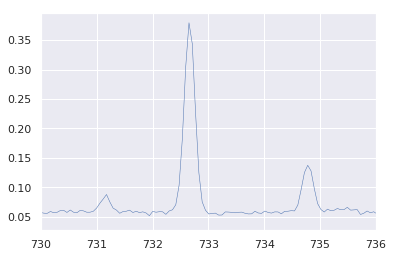

In [35]:
fig,ax = plt.subplots()
plt.plot(wavelength_range, test_cube[:,25,25], linewidth = 0.5)
# plt.plot(wavelength_range, central_flux, sns.xkcd_rgb["pale red"], linewidth = 0.5)
ax.set_xlim(730, 736)